### Natural Language Processing Script

This script can be used as a standalone program to process and prepare topic modelling of the ```Scraper.py``` datasets generated.

### 1.0 <u>Code:</u>

Here, we import the libraries required to run the script.

In [1]:
'''Natural Language toolkit. Here we download the commonly used English stopwords'''
import nltk; nltk.download('stopwords')
'''Standard set of functions for reading and appending files'''
import re
'''Pandas and numpy is a dependency used by other portions of the code.'''
import numpy as np
import pandas as pd
'''Think this stands for pretty print. Prints out stuff to the terminal in a prettier way'''
from pprint import pprint

'''Contains the language model that has to be developed.'''
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
'''Industrial level toolkit for NLP'''
import spacy

'''Importing OS here to build the directories to hold the status logger logs'''
import os

import pyLDAvis
import pyLDAvis.gensim

'''Importing datetime here to log the time when specfic functions are triggered'''
from datetime import datetime

'''Make pretty visualizations'''
import matplotlib.pyplot as plt

'''Library to log any errors. Came across this in the tutorial.'''
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'com', 'https', 'url', 'link', 'xe', 'abstract', 'author', 'chapter', 'springer', 'title', "the", "of", "and", "in", "to", "a", "is", "for", "from", "with", "that","by", "are", "on", "was", "as", "were", "url:", "abstract:", "abstract",  "author:", "title:", "at", "be", "an", "during", "have", "this", "which", "study", "been", "species", "not", "has", "between", "using", "its", "also", "these", "this", "used", "over", "can", "within", "into", "all","due", "use", "about", "a", 'it', 'their', "where", "we", "most", "may", "through", "though", "like", "or", "further", "e.g.", "along", "any", "those", "had", "toward", "due", "both", "some", "use", "even", "more", "but", "while", "pass", "well", "will", "when", "only", "after", "author", "title", "there", "our", "did", "much", "as", "if", "become", "still", "various", "very", "out", "they", "via", "available", "such", "than", "different", "many", "areas", "no", "one", "two", "small", "first", "other", "such", "-", "could", "studies", "high","provide", "among", "highly", "no", "case", "across", "given", "need", "would", "under", "found", "low", "values", "xe2\\x80\\x89"])

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sarthak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Defining the abstracts log name that will be processed by the rest of the script. The status logger function of the main script has been imported here, and the name of the ```.txt``` file used to log the information has to be added here.

In [2]:
abstracts_log_name = "/home/sarthak/projects/Bias/BackUp_Journal_LOGS/Test_Bed_Master_Copy/CompletelyCleanCorpus_10_Topics"
session_folder_name = abstracts_log_name.split('/')[7]
os.makedirs(session_folder_name)
status_logger_name = session_folder_name+"/"+"Status_Logger"+"_"+abstracts_log_name.split('/')[7]

This function is responsible for generating a ```.txt``` file for analysis once the code has run. This code has been copied directly from the ```common_functions.py``` script of the main code.

In [3]:
def status_logger(status_logger_name, status_key):
	'''Status logger to print and log details throught the running the program.
	Declaring current_hour, current_minute & current_second.'''
	current_hour = str(datetime.now().time().hour)
	current_minute = str(datetime.now().time().minute)
	current_second = str(datetime.now().time().second)
	'''Logging the complete_status_key and printing the complete_status_key'''
	complete_status_key = "[INFO]"+current_hour+":"+current_minute+":"+current_second+" "+status_key
	print(complete_status_key)
	status_log = open(status_logger_name+'.txt', 'a')
	status_log.write(complete_status_key+"\n")
	status_log.close()

Here, we read the ```.txt``` file generated from the journal scrapping, that has to be profiled using topic models.

In [4]:
def data_reader(abstracts_log_name, status_logger_name):
	data_reader_start_status_key = abstracts_log_name+".txt is being ported to dataframe"
	status_logger(status_logger_name, data_reader_start_status_key)
	textual_dataframe = pd.read_csv(abstracts_log_name+'.txt', delimiter="\t")
	data_reader_end_status_key = abstracts_log_name+".txt has been ported to dataframe"	
	status_logger(status_logger_name, data_reader_end_status_key)
	return textual_dataframe

Taking the abstracts and preparing a list of abstracts.

In [5]:
def textual_data_trimmer(textual_dataframe, status_logger_name):
	textual_data_trimmer_start_status_key = "Trimming data and preparing list of words"
	status_logger(status_logger_name, textual_data_trimmer_start_status_key)

	'''This function converts the textual data into a list and removes special characters, virtue of email correspondence'''
	textual_data = textual_dataframe.values.tolist()
	print(textual_data)

	textual_data_trimmer_end_status_key = "Trimmed data and prepared list of words"
	status_logger(status_logger_name, textual_data_trimmer_end_status_key)
	return textual_data

Tokenizing the words here and also removing punctuations from the corpus.

In [6]:
def sent_to_words(textual_data, status_logger_name):
	sent_to_words_start_status_key = "Tokenizing words"
	status_logger(status_logger_name, sent_to_words_start_status_key)
	'''This function tokenizes each sentence into individual words; also called tokens'''
	for sentence in textual_data:
		yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
	textual_data = list(sent_to_words(textual_data))
	sent_to_words_end_status_key = "Tokenized words"
	status_logger(status_logger_name, sent_to_words_end_status_key)	
	return textual_data

Generating ***```bigrams```*** from the ```textual_data``` that we have prepared from the abstracts. **Bigrams** are words that occur together, multiple times in a given body of text. For example, *torrential* and *rain* occur together more often with each other, as opposed to other adjective-noun pairs. Hence the two would form a bigram here.

In [7]:
def bigram_generator(textual_data, status_logger_name):
	bigram_generator_start_status_key = "Generating word bigrams"
	status_logger(status_logger_name, bigram_generator_start_status_key)	
	'''Takes the textual data and prepares the bigram, two collectively high frequency words'''
	bigram = gensim.models.Phrases(textual_data, min_count=5, threshold=100)
	bigram_mod = gensim.models.phrases.Phraser(bigram)
	bigram_generator_end_status_key = "Generated word bigrams"
	status_logger(status_logger_name, bigram_generator_end_status_key)	
	return bigram_mod

Here, we use the ```bigram_mod``` model to generate bigrams from our ```corpus```.

In [8]:
def make_bigrams(textual_data, status_logger_name):
	'''Generates multiple bigrams of word pairs in phrases that commonly occuring with each other over the corpus'''
	make_bigrams_start_status_key = "Generating bigrams"
	status_logger(status_logger_name, make_bigrams_start_status_key)

	bigram_mod = bigram_generator(textual_data, status_logger_name)
	return [bigram_mod[doc] for doc in textual_data]

	make_bigrams_end_status_key = "Generated bigrams"

We remove the stopwords, as specified in a list at the start of the program. There's a marked improvement in the topics and keywords produced after expanding the cache of the words to be filtered out.

In [9]:
def remove_stopwords(textual_data, status_logger_name):
	'''This function removes the standard set of stopwords from the corpus of abstract words'''
	remove_stopwords_start_status_key = "Removing stopwords"
	status_logger(status_logger_name, remove_stopwords_start_status_key)
	return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in textual_data]
	remove_stopwords_end_status_key = "Removed stopwords"
	status_logger(status_logger_name, remove_stopwords_end_status_key)

Generating the ```pyLDAvis``` visualization from the ```lda_model``` generated and trained on our ```corpus``` & ```id2word``` dictionary. The time taken here is proportional to the size of the ```corpus```.

In [10]:
def visualizer_generator(lda_model, corpus, id2word, logs_folder_name, status_logger_name):
	'''This code generates the .html file with generates the visualization of the data prepared.'''
	visualizer_generator_start_status_key = "Preparing the topic modeling visualization"
	status_logger(status_logger_name, visualizer_generator_start_status_key)
    
	textual_data_visualization = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
	pyLDAvis.save_html(textual_data_visualization, session_folder_name+'/'+"Data_Visualization_Topic_Modelling.html")

	visualizer_generator_end_status_key = "Prepared the topic modeling visualization"+" "+"Data_Visualization_Topic_Modelling.html"
	status_logger(status_logger_name, visualizer_generator_end_status_key)

Lemmatization involves truncating a term to its root term. For example *running -> run* is an example of the ```lemmatization``` process.

In [11]:
def lemmatization(status_logger_name, textual_data, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
	lemmatization_start_status_key = "Beginning lemmatization"
	status_logger(status_logger_name, lemmatization_start_status_key)
	"""https://spacy.io/api/annotation"""
	texts_out = []
	nlp = spacy.load('en', disable=['parser', 'ner'])
	for sent in textual_data:
		doc = nlp(" ".join(sent))
		texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
	lemmatization_end_status_key = "Ending lemmatization"
	status_logger(status_logger_name, lemmatization_end_status_key)
	return texts_out

Calling the ```nlp_engine_main()``` function where all the previously defined functions come together and generate the ```pyLDAvis``` visualization for topic analysis.

In [12]:
nlp_engine_main_start_status_key = "Initiating the NLP Engine"
status_logger(status_logger_name, nlp_engine_main_start_status_key)

'''Extracts the data from the .txt file and puts them into a Pandas dataframe buckets'''
textual_dataframe = data_reader(abstracts_log_name, status_logger_name)
'''Rids the symbols and special characters from the textual_data'''
textual_data = textual_data_trimmer(textual_dataframe, status_logger_name)
'''Removes stopwords that were earlier downloaded from the textual_data'''
textual_data_no_stops = remove_stopwords(textual_data, status_logger_name)
'''Prepares bigrams'''
textual_data_words_bigrams = make_bigrams(textual_data_no_stops, status_logger_name)
'''Loads the English model from spaCy'''
nlp = spacy.load('en', disable=['parser', 'ner'])

textual_data_lemmatized = lemmatization(status_logger_name, textual_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

id2word = corpora.Dictionary(textual_data_lemmatized)

texts = textual_data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

'''Builds the actual LDA model that will be used for the visualization and inference'''
lda_model = gensim.models.ldamodel.LdaModel(corpus = corpus, id2word = id2word, num_topics = 10, random_state = 100, update_every = 1, chunksize = 100, passes = 10, alpha = 'symmetric', per_word_topics = True)

doc_lda = lda_model[corpus]

perplexity_score = lda_model.log_perplexity(corpus)

perplexity_status_key = "Issued perplexity:"+" "+str(perplexity_score)

status_logger(status_logger_name, perplexity_status_key)

nlp_engine_main_end_status_key = "Idling the NLP Engine"
status_logger(status_logger_name, nlp_engine_main_end_status_key)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[INFO]9:13:26 Generating bigrams
[INFO]9:13:26 Generating word bigrams
[INFO]9:13:33 Generated word bigrams
[INFO]9:13:35 Beginning lemmatization
[INFO]9:13:57 Ending lemmatization
[INFO]9:14:33 Issued perplexity: -8.617273238774697
[INFO]9:14:33 Idling the NLP Engine


In [13]:
lda_model

Presenting the topics of the trained ```LDA``` model here.

In [14]:
lda_model.print_topics()

[(0,
  '0.029*"river" + 0.020*"water" + 0.015*"biology" + 0.015*"lake" + 0.015*"ecology" + 0.014*"aquatic" + 0.013*"microorganism" + 0.013*"freshwater" + 0.012*"algae" + 0.009*"together"'),
 (1,
  '0.087*"population" + 0.035*"model" + 0.030*"extinction" + 0.027*"decline" + 0.026*"change" + 0.018*"people" + 0.016*"rate" + 0.015*"hunt" + 0.012*"sustainable" + 0.011*"fishery"'),
 (2,
  '0.046*"stream" + 0.045*"urban" + 0.037*"specialist" + 0.022*"emerge" + 0.019*"trait" + 0.015*"seabird" + 0.015*"body" + 0.014*"meadow" + 0.013*"generalist" + 0.013*"peat"'),
 (3,
  '0.029*"habitat" + 0.015*"site" + 0.013*"community" + 0.009*"increase" + 0.009*"bird" + 0.008*"effect" + 0.008*"vegetation" + 0.008*"abundance" + 0.007*"diversity" + 0.007*"large"'),
 (4,
  '0.026*"conservation" + 0.018*"biodiversity" + 0.008*"protect" + 0.007*"management" + 0.006*"resource" + 0.005*"ecological" + 0.005*"local" + 0.005*"reserve" + 0.005*"base" + 0.005*"development"'),
 (5,
  '0.033*"soil" + 0.031*"plant" + 0.027

Declaring the ```mallet``` path here. Part of the GitHub package that you've cloned.

In [15]:
mallet_path = '/home/sarthak/projects/Bias/mallet-2.0.8/bin/mallet'

Building the ```LDA mallet``` model here, to generate the representative documents, run the coherence tests and issue perplexity here.

In [16]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=10, id2word=id2word)

Just checking out the topics of the ```LDA mallet``` model here.

In [1]:
(ldamallet.show_topics(topn = 15, formatted=False))

NameError: name 'ldamallet' is not defined

Presenting the "Coherence" of the model here. Coherence is a proxy for how well the model has been built and trained.

In [18]:
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=textual_data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.4423353360144534


Presenting the coherence here for a bunch of trained models. Will be eventually selecting the ```optimal_model``` as the ```lda_model```, to get the representative documents with corresponding ```num_topics```.

In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

Computing coherence from the previously generated ```mallet``` models, to find the model with the best coherence, and thereby the best model.

In [20]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=textual_data_lemmatized, start=2, limit=40, step=6)

Plotting the computed coherence scores here for the models that we generated.

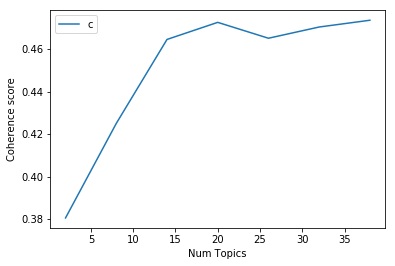

In [21]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

Declaring the ```optimal_model``` as the previously generated ```ldamallet``` model.

In [22]:
optimal_model = ldamallet

Presenting the topics of the ```ldamallet``` model here.

In [23]:
model_topics = optimal_model.show_topics(formatted=False)

```num_words``` dictates the number of keywords to be presented with each topic.

In [24]:
pprint(optimal_model.print_topics(num_words=40))

[(0,
  '0.017*"ecosystem" + 0.017*"soil" + 0.016*"community" + 0.012*"water" + '
  '0.011*"impact" + 0.009*"river" + 0.009*"wetland" + 0.008*"change" + '
  '0.008*"show" + 0.008*"fish" + 0.008*"site" + 0.007*"coastal" + '
  '0.007*"marine" + 0.007*"increase" + 0.007*"environment" + 0.007*"level" + '
  '0.006*"invertebrate" + 0.006*"assemblage" + 0.006*"aquatic" + 0.005*"time" '
  '+ 0.005*"organism" + 0.005*"associate" + 0.005*"important" + '
  '0.005*"condition" + 0.005*"stream" + 0.005*"pond" + 0.005*"year" + '
  '0.005*"occur" + 0.005*"period" + 0.004*"freshwater" + 0.004*"suggest" + '
  '0.004*"lake" + 0.004*"system" + 0.004*"mediterranean" + 0.004*"biomass" + '
  '0.004*"include" + 0.004*"complex" + 0.004*"surface" + 0.004*"reach" + '
  '0.004*"terrestrial"'),
 (1,
  '0.053*"habitat" + 0.030*"vegetation" + 0.026*"landscape" + '
  '0.021*"community" + 0.021*"site" + 0.020*"effect" + 0.018*"abundance" + '
  '0.017*"grassland" + 0.016*"type" + 0.015*"land" + 0.013*"composition" + '
 

This function computes the dominant topic in each sentence. We use this meta-data as a part of our framework to understand under which areas of research do the publications fall in, and also to label each of the ```pyLDAvis``` topics.

In [25]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=textual_data):
    sent_topics_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

Generating the ```dataframes``` here which contains the dominant topics for each abstract.

In [26]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=textual_data)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.3043,"ecosystem, soil, community, water, impact, riv...",[Abstract: 'Maintenance of soil health is cent...
1,1,5.0,0.3874,"diversity, richness, pattern, group, high, sho...",[Abstract: 'Plant invasion is highly responsiv...
2,2,3.0,0.5268,"model, distribution, change, factor, scale, ha...","[Abstract: 'Globally, treeline in mountain lan..."
3,3,0.0,0.3233,"ecosystem, soil, community, water, impact, riv...",[Abstract: 'Forests play a crucial role by reg...
4,4,5.0,0.4221,"diversity, richness, pattern, group, high, sho...",[Abstract: 'The analysis of species distributi...
5,5,3.0,0.2687,"model, distribution, change, factor, scale, ha...",[Abstract: 'The Himalayan ecosystem is one of ...
6,6,3.0,0.5149,"model, distribution, change, factor, scale, ha...","[Abstract: 'In an era of climate change, predi..."
7,7,2.0,0.2660,"plant, native, region, endemic, island, record...",[Abstract: 'The relationship and its key predi...
8,8,5.0,0.3978,"diversity, richness, pattern, group, high, sho...",[Abstract: 'Climate change effects on Himalaya...
9,9,3.0,0.3969,"model, distribution, change, factor, scale, ha...",[Abstract: 'With the threats of climate change...


Saving the ```dataframe``` to disc for analysis.

In [27]:
df_dominant_topic.to_csv(session_folder_name+'/Master_Topic_Per_Centence.csv')

Here we find the most representative document for each topic, and contain it in a ```dataframe``` and save it as a ```.csv```

In [28]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')
for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], axis=0)

In [29]:
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]
sent_topics_sorteddf_mallet.head()
sent_topics_sorteddf_mallet.to_csv(session_folder_name+'/Master_Topics_Contribution.csv')

Here, we find the number of documents for each topic.

In [30]:
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

Here, we find the percentage of documents falling under each topic.

In [31]:
topic_contribution = round(topic_counts/topic_counts.sum(), 4)
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

Presenting the dominant topics in each sentence here.

In [32]:
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0.0,"ecosystem, soil, community, water, impact, riv...",680.0,0.1437
1,5.0,"diversity, richness, pattern, group, high, sho...",533.0,0.1126
2,3.0,"model, distribution, change, factor, scale, ha...",413.0,0.0873
3,0.0,"ecosystem, soil, community, water, impact, riv...",296.0,0.0625
4,5.0,"diversity, richness, pattern, group, high, sho...",634.0,0.1340
5,3.0,"model, distribution, change, factor, scale, ha...",357.0,0.0754
6,3.0,"model, distribution, change, factor, scale, ha...",391.0,0.0826
7,2.0,"plant, native, region, endemic, island, record...",416.0,0.0879
8,5.0,"diversity, richness, pattern, group, high, sho...",490.0,0.1035
9,3.0,"model, distribution, change, factor, scale, ha...",523.0,0.1105


Saving it to a ```.csv``` bucket here.

In [33]:
df_dominant_topics.to_csv(session_folder_name+'/Master_Topics.csv')

Generating the visualization here from the ```lda_model```. We use this to label the broad areas of research, in syn which the representative documents generated above.

In [34]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)

/home/sarthak/.local/lib/python3.5/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


Enabling the visualizations in the notebook here.

In [35]:
pyLDAvis.enable_notebook()

Saving the visualization to the disk, as an ```.html``` file in the sessions folder.

In [36]:
pyLDAvis.save_html(vis, session_folder_name+'/Master.html')

Presenting the ```pyLDAvis``` visualization here.

In [37]:
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
4      35.030567        1       1 -0.256223  0.137426
3      29.264191        1       2 -0.286898  0.028521
6      15.934057        1       3 -0.254672 -0.021817
8       7.457654        1       4 -0.106953 -0.316568
1       3.877349        1       5  0.044581  0.207853
5       2.490911        1       6  0.123937 -0.010623
0       2.377101        1       7  0.169726 -0.070933
9       1.953680        1       8  0.167598  0.035577
2       0.964099        1       9  0.199106  0.004656
7       0.650390        1      10  0.199799  0.005907, topic_info=      Category         Freq                  Term        Total  loglift  \
19344  Default  6142.000000                forest  6142.000000  30.0000   
7315   Default  2866.000000            population  2866.000000  29.0000   
20962  Default  2853.000000                 plant  2853.000000  28.0000   
8578   Default  1781.000000                  tree  1781.000000  27.0000   
3250   Default  4514.000000               habitat  4514.000000  26.0000   
2342   Default  4797.000000          conservation  4797.000000  25.0000   
18693  Default  4101.000000             diversity  4101.000000  24.0000   
21017  Default  1391.000000                change  1391.000000  23.0000   
10855  Default   843.000000                island   843.000000  22.0000   
21161  Default  1134.000000                 model  1134.000000  21.0000   
13304  Default  1041.000000                  soil  1041.000000  20.0000   
18375  Default  2727.000000              richness  2727.000000  19.0000   
17569  Default  1670.000000          distribution  1670.000000  18.0000   
16647  Default   805.000000               decline   805.000000  17.0000   
3241   Default   633.000000                  seed   633.000000  16.0000   
19159  Default  3440.000000          biodiversity  3440.000000  15.0000   
22279  Default  1223.000000               endemic  1223.000000  14.0000   
221    Default   551.000000                native   551.000000  13.0000   
19137  Default   650.000000            extinction   650.000000  12.0000   
17736  Default  1337.000000               pattern  1337.000000  11.0000   
18809  Default  2900.000000                  site  2900.000000  10.0000   
4747   Default   714.000000                  rate   714.000000   9.0000   
22853  Default  2585.000000                number  2585.000000   8.0000   
21396  Default  1807.000000              increase  1807.000000   7.0000   
23534  Default   894.000000                impact   894.000000   6.0000   
94     Default  1480.000000                sample  1480.000000   5.0000   
17008  Default  1013.000000                  taxa  1013.000000   4.0000   
6259   Default   881.000000               genetic   881.000000   3.0000   
8297   Default  1338.000000                effect  1338.000000   2.0000   
16876  Default  1272.000000                  bird  1272.000000   1.0000   
...        ...          ...                   ...          ...      ...   
13048  Topic10   119.166138           undisturbed   120.311539   5.0258   
4592   Topic10   107.429771                 other   108.575378   5.0247   
22782  Topic10    82.142380                 algal    83.288300   5.0215   
12562  Topic10    78.639000             bryophyte    79.784294   5.0209   
9086   Topic10    54.281155                  root    55.426632   5.0145   
17670  Topic10    50.138218              overview    51.283806   5.0128   
22007  Topic10    49.349297            downstream    50.494839   5.0124   
15293  Topic10    47.711067                arctic    48.857212   5.0116   
6987   Topic10    38.620758                   ice    39.766350   5.0061   
14085  Topic10    36.211536                 spore    37.357079   5.0042   
12424  Topic10    34.560062       liquid_nitrogen    35.705784   5.0027   
5563   Topic10    33.824402           extensively    34.970024   5.0020   
5293   To